In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from sklearn.metrics import confusion_matrix, silhouette_score, calinski_harabasz_score, davies_bouldin_score,balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from matplotlib import pyplot as plt
import lightgbm as lgb
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
data=pd.read_csv("../data/data.csv")
data=data.drop("id",axis=1)
ss=pd.read_csv("../data/sample_submission.csv")

In [3]:
best_data =['f_07','f_08', 'f_09', 'f_10','f_11', 'f_12', 'f_13', 'f_22','f_23', 'f_24', 'f_25','f_26','f_27', 'f_28']

rob_scaler = RobustScaler().fit(data)
power_transformer = PowerTransformer().fit(data)

data_scaled = rob_scaler.fit_transform(data[best_data])
data_scaled = power_transformer.fit_transform(data_scaled)
train = pd.DataFrame(data_scaled, columns = best_data)

In [4]:
BGM = BayesianGaussianMixture(n_components=7,covariance_type='full',random_state=1,n_init=5,tol=0.001,max_iter=400)
# fit model and predict clusters
preds = BGM.fit_predict(train)
pp=BGM.predict_proba(train)

In [8]:
train[[f'predict_proba_{i}' for i in range(7)]]=pp # creating new dataframe columns of probabilites 
train['predict_proba']=np.max(pp,axis=1)
train['predict']=np.argmax(pp,axis=1)
    
trn_indx=np.array([])
for n in range(7):
    # using only those index whoose predicted probablity > 80
    indx=train[(train.predict==n) & (train.predict_proba > 0.75)].index 
    trn_indx = np.concatenate((trn_indx, indx))
    
X = train.loc[trn_indx][best_data]
y = train.loc[trn_indx]['predict']
print(X.shape)
print(y.shape)


(69089, 14)
(69089,)


In [9]:
params_lgb = {'learning_rate': 4e-2,'objective': 'multiclass','boosting': 'gbdt','verbosity': -1,'n_jobs': -1, 'num_classes':7,
    'random_state': 42} 

lgbm_predict_proba = 0  
ctb_predict_proba = 0
qda_predict_proba = 0
svc_predict_proba = 0

classif_scores = []

gkf = StratifiedKFold(10, shuffle=True, random_state = 1)
for fold, (trn, val) in enumerate(gkf.split(X,y)):  
    
    X_train, y_train = X.iloc[trn], y.iloc[trn]
    X_valid, y_valid = X.iloc[val], y.iloc[val]

    X_trn = lgb.Dataset(X_train, y_train)
    X_val = lgb.Dataset(X_valid, y_valid)
    
    model = lgb.train(params = params_lgb, 
                train_set = X_trn, valid_sets =  X_val, 
                num_boost_round = 5000, 
                callbacks = [ lgb.early_stopping(stopping_rounds=100, verbose=True), lgb.log_evaluation(period=200)])  
    
    y_pred_proba = model.predict(X.iloc[val])
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    s = (balanced_accuracy_score(y.iloc[val], y_pred),
        roc_auc_score(y.iloc[val], y_pred_proba, average="weighted", multi_class="ovo"))
    print(f"LightGBM   AUC : {s[1]:.3f} | Accuracy : {s[0]:.1%}")
    classif_scores.append(s)

    lgbm_predict_proba += model.predict(train[best_data]) / 10
    
    
pd.DataFrame(classif_scores, columns = ["balanced_accuracy_score", "roc_auc_score"]).mean(0)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's multi_logloss: 0.0567097
[400]	valid_0's multi_logloss: 0.0260486
[600]	valid_0's multi_logloss: 0.0178706
[800]	valid_0's multi_logloss: 0.0153598
[1000]	valid_0's multi_logloss: 0.0145647
[1200]	valid_0's multi_logloss: 0.0142026
[1400]	valid_0's multi_logloss: 0.0145183
Early stopping, best iteration is:
[1306]	valid_0's multi_logloss: 0.0141158
LightGBM   AUC : 1.000 | Accuracy : 99.4%
Training until validation scores don't improve for 100 rounds
[200]	valid_0's multi_logloss: 0.0574437
[400]	valid_0's multi_logloss: 0.0278214
[600]	valid_0's multi_logloss: 0.0206027
[800]	valid_0's multi_logloss: 0.0180547
[1000]	valid_0's multi_logloss: 0.0173457
Early stopping, best iteration is:
[978]	valid_0's multi_logloss: 0.0172911
LightGBM   AUC : 1.000 | Accuracy : 99.5%
Training until validation scores don't improve for 100 rounds
[200]	valid_0's multi_logloss: 0.0568598
[400]	valid_0's multi_logloss: 0.0273409

balanced_accuracy_score    0.994286
roc_auc_score              0.999968
dtype: float64

In [13]:
print(len(lgbm_predict_proba))

98000


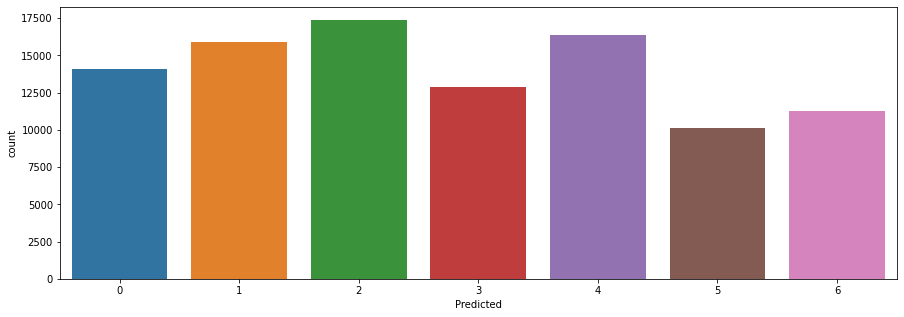

In [11]:
ss.Predicted=np.argmax(lgbm_predict_proba,axis=1)
ss.to_csv("submission_lgbm.csv",index=False)

plt.figure(figsize=(15,5))
sns.countplot(x=ss.Predicted)
plt.show()